In [223]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [224]:
def get_mig_uuids():
    result = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"Command 'nvidia-smi -L' failed with exit code {result.returncode}")
    output = result.stdout
    mig_uuid_pattern = re.compile(r'MIG-[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}')
    mig_uuids = mig_uuid_pattern.findall(output)
    return mig_uuids
def set_cuda_visible_devices(mig_uuids):
    mig_uuids_str = ','.join(mig_uuids)
    os.environ['CUDA_VISIBLE_DEVICES'] = mig_uuids_str
    print(f"CUDA_VISIBLE_DEVICES set to: {mig_uuids_str}")
    mig_uuids = get_mig_uuids()
    if mig_uuids:
        set_cuda_visible_devices(mig_uuids)
    else:
        print("No MIG devices found.")

In [225]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [226]:
labels = ['glioma', 'notumor', 'meningioma', 'pituitary']

class_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

inverse_class_map = {
    0: 'notumor',
    1: 'glioma',
    2: 'meningioma',
    3: 'pituitary'
}

In [227]:
h, w = 224, 224
batch_size = 32
epochs = 40
learning = 0.001

In [228]:
IMAGES = []
LABELS = []
train_path = path + '/Training'

for label in labels:
    folderPath = os.path.join(train_path, label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (h, w))  # Resize image
        IMAGES.append(img)
        LABELS.append(class_map[label])

# Convert lists to NumPy arrays
X_train = np.array(IMAGES)
y_train = np.array(LABELS)


100%|██████████| 1457/1457 [00:01<00:00, 731.89it/s]


In [229]:
folders = os.listdir(train_path)
print("Folders in dataset:", folders)

Folders in dataset: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [230]:
for folder in folders:
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        print(f"Folder: {folder}, Number of files: {len(files)}")

Folder: glioma, Number of files: 1321
Folder: meningioma, Number of files: 1339
Folder: notumor, Number of files: 1595
Folder: pituitary, Number of files: 1457


In [231]:
if len(y_train) > 0:
    print("y_train is not empty. It contains", len(y_train), "elements.")
else:
    print("y_train is empty.")

y_train is not empty. It contains 5712 elements.


In [232]:
IMAGES = []
LABELS = []
test_path = path + '/Testing'

for label in labels:
    folderPath = os.path.join(test_path, label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (h, w))  # Resize image
        IMAGES.append(img)
        LABELS.append(class_map[label])

# Convert lists to NumPy arrays
X_test = np.array(IMAGES)
y_test = np.array(LABELS)


100%|██████████| 300/300 [00:00<00:00, 820.49it/s]


In [233]:
if len(y_test) > 0:
    print("y_test is not empty. It contains", len(y_test), "elements.")
else:
    print("y_test is empty.")

y_train is not empty. It contains 1311 elements.


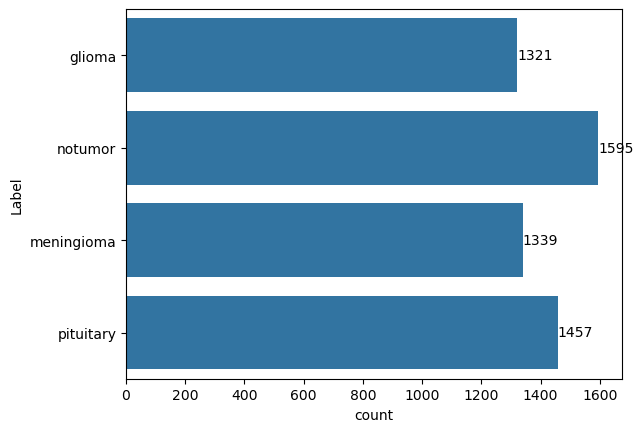

In [234]:
y_train_labels = [inverse_class_map[label] for label in y_train]
train_dataframe = pd.DataFrame({'Label': y_train_labels})

x = sns.countplot(data=train_dataframe, y="Label")
for container in x.containers:
    x.bar_label(container)
    
plt.show()

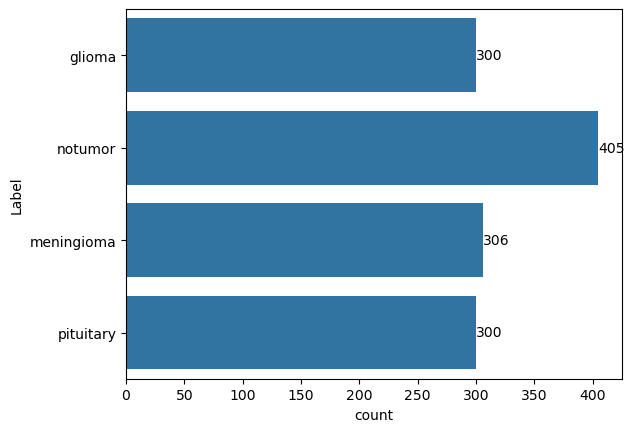

In [235]:
y_test_labels = [inverse_class_map[label] for label in y_test]
test_dataframe = pd.DataFrame({'Label': y_test_labels})

x = sns.countplot(data=test_dataframe, y="Label")
for container in x.containers:
    x.bar_label(container)
    
plt.show()

In [236]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

X_train = X_train.reshape(X_train.shape[0], h, w, 3)  # Assuming 3 channels (RGB)
X_test = X_test.reshape(X_test.shape[0], h, w, 3)

In [237]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [238]:
model.compile(Adamax(learning_rate= learning),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

In [239]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,652 (19.48 MB)

 Trainable params: 5,107,652 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [240]:
datagen = ImageDataGenerator(
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom into images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill
)

In [241]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [242]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

results = model.evaluate(X_test, y_test)
print("Accuracy:", results[1])

Epoch 1/40


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 277ms/step - accuracy: 0.4103 - loss: 1.2337 - precision_5: 0.6551 - recall_5: 0.1335 - val_accuracy: 0.6278 - val_loss: 1.0067 - val_precision_5: 0.7638 - val_recall_5: 0.3799
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 249ms/step - accuracy: 0.6405 - loss: 0.8811 - precision_5: 0.7592 - recall_5: 0.4254 - val_accuracy: 0.7086 - val_loss: 0.7668 - val_precision_5: 0.7949 - val_recall_5: 0.6148
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.6769 - loss: 0.7909 - precision_5: 0.7464 - recall_5: 0.5516 - val_accuracy: 0.6705 - val_loss: 0.8695 - val_precision_5: 0.7199 - val_recall_5: 0.6018
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.7317 - loss: 0.6970 - precision_5: 0.7912 - recall_5: 0.6414 - val_accuracy: 0.7155 - val_loss: 0.6945 - val_precision_5: 0.7556 - val_recall_5: 0.6674
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.7505 - loss: 0.6471 - precision_5: 0.8010 - recall_5: 0.68

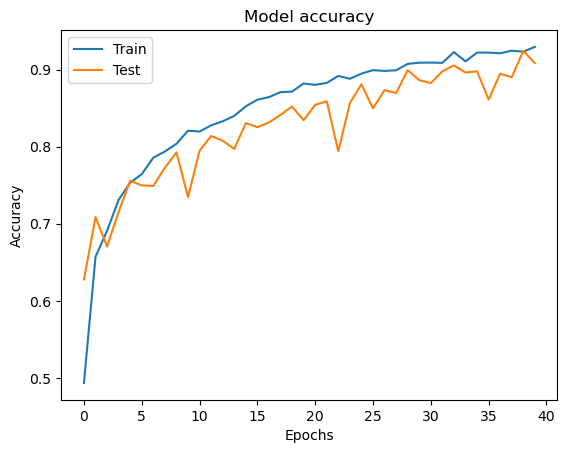

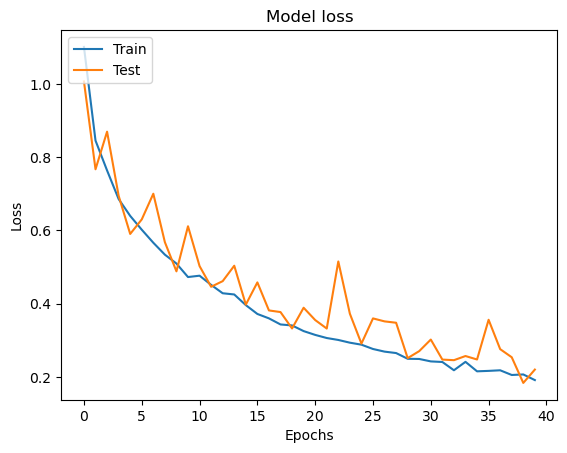

In [244]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [247]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9293 - loss: 0.1646 - precision_5: 0.9319 - recall_5: 0.9252
Test Accuracy: 92.45%
Test Loss: 0.1833
